## 4.3 STL Features
The STL decomposition discussed in Chapter 3 is the basis for several more features.

A time series decomposition can be used to measure the strength of trend and seasonality in a time series. Recall that the decomposition is written as
$$
y_t = T_t + S_t + R_t,
$$
where $T_t$ is the smoothed trend component, $S_t$ is the seasonal component and $R_t$ is a remainder component. For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component. Therefore $\mathrm{Var}(R_t)/\mathrm{Var}(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So we define the strength of trend as:

$$
F_T = \max\left(0, 1-\frac{\mathrm{Var}(R_t)}{\mathrm{Var}(T_t+R_t)}\right).
$$
This will give a measure of the strength of the trend between 0 and 1. Because the variance of the remainder might occasionally be even larger than the variance of the seasonally adjusted data, we set the minimal possible value of $F_T$ equal to zero.

The strength of seasonality is defined similarly, but with respect to the detrended data rather than the seasonally adjusted data:
$$
F_S = \max\left(0, 1-\frac{\mathrm{Var}(R_t)}{\mathrm{Var}(S_t+R_t)}\right).
$$
A series with seasonal strength $F_S$ close to 0 exhibits almost no seasonality, while a series with strong seasonality will have $F_S$ close to 1.

These measures can be useful, for example, when you have a large collection of time series, and you need to find the series with the most trend or the most seasonality.

We can then use these features in plots to identify what type of series are heavily trended and what are most seasonal.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../')
from utils import compute, summarize

In [56]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
from plotnine import ggplot, aes, geom_point, facet_wrap, theme, labs, geom_line, facet_grid

In [29]:
def compute_trend_strength(stl):
    return max(0, 1-stl.resid.var()/(stl.trend + stl.resid).var())

In [30]:
def compute_season_strength(stl):
    return max(0, 1-stl.resid.var()/(stl.seasonal + stl.resid).var())

In [23]:
tourism = (
    pd.read_csv('../data/tsibble/tourism.csv')
    .assign(date=lambda df: pd.to_datetime(df['Quarter'].str.replace(' ', '')))
    .set_index('date', drop=False)
)


In [33]:
results = (
    tourism
    .groupby(['Region', 'State', 'Purpose'])
    .pipe(summarize, lambda x: dict(stl=STL(x.Trips, robust=False).fit()))
    .pipe(compute, lambda x: dict(
        trend_strength=[compute_trend_strength(stl) for stl in x.stl],
        season_strength=[compute_season_strength(stl) for stl in x.stl]))
    .reset_index()
    .drop(columns='stl')
)

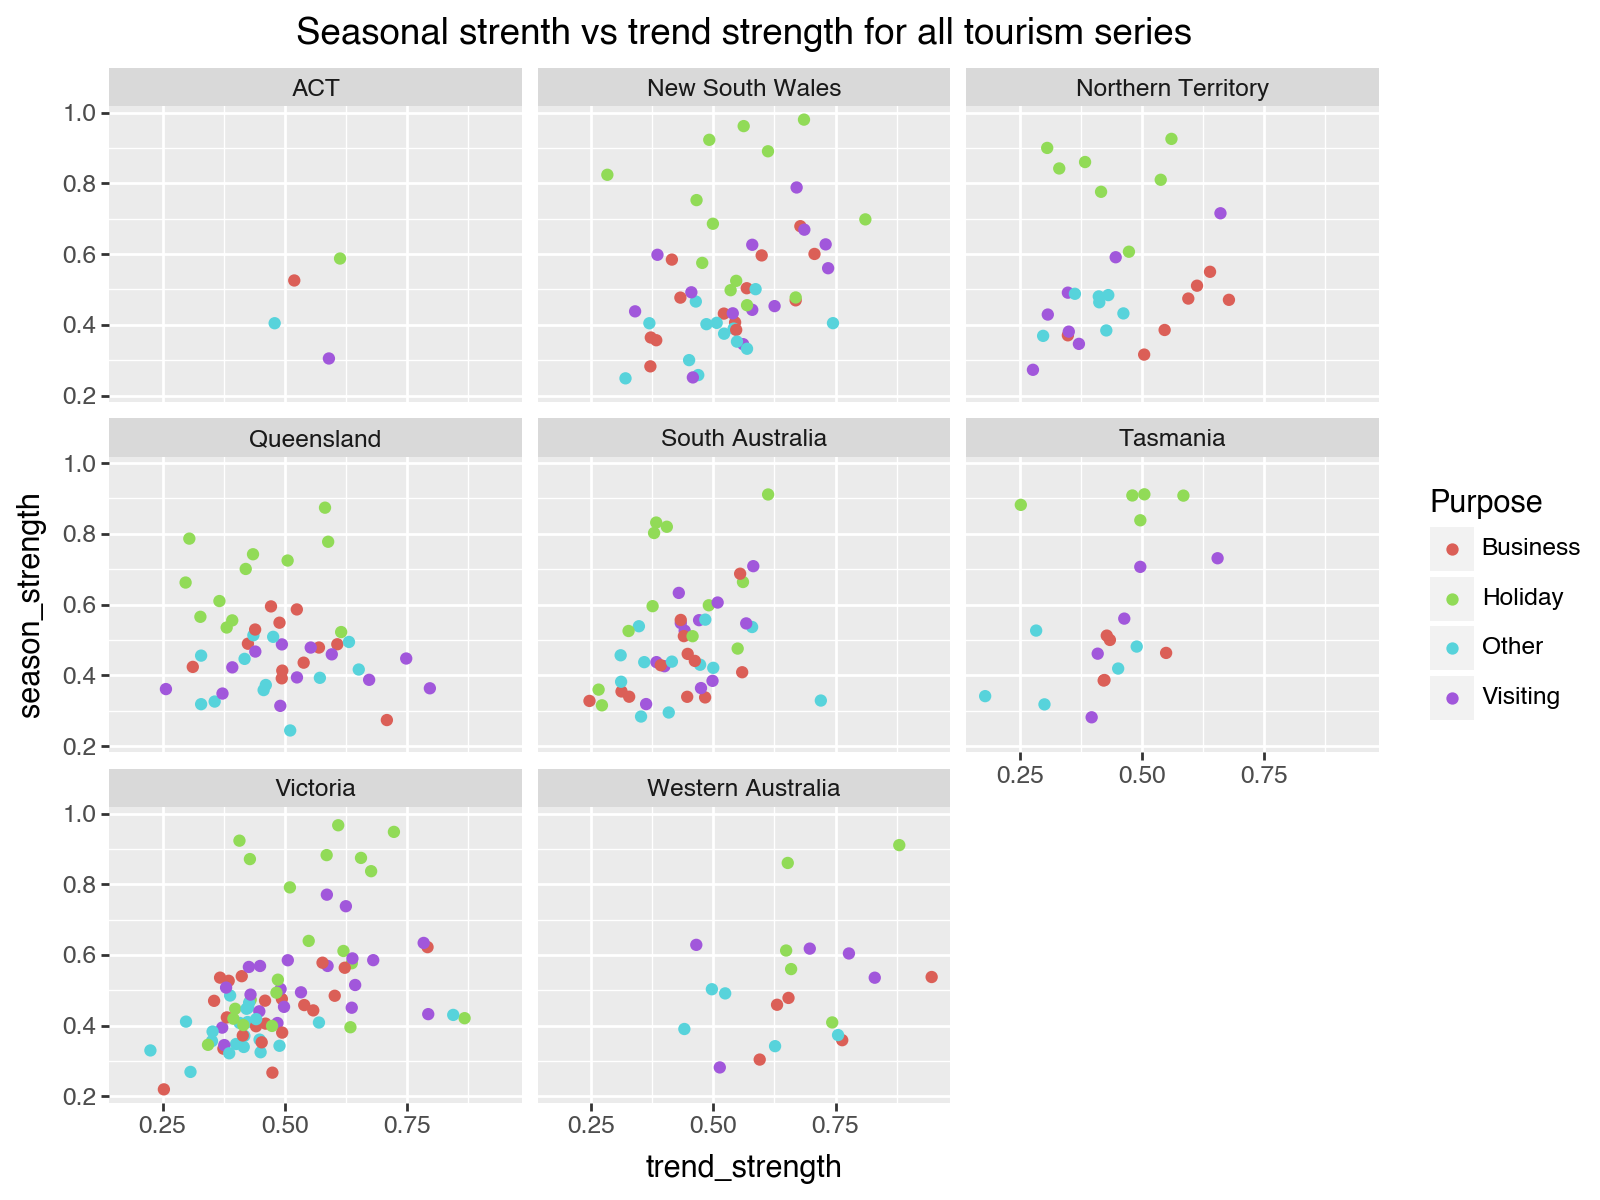

In [46]:
ggplot(results) \
    + aes(x='trend_strength', y='season_strength', color='Purpose') \
    + geom_point() \
    + facet_wrap("State") \
    + labs(title='Seasonal strenth vs trend strength for all tourism series') \
    + theme(figure_size=(8, 6))

Plot the most seasonal series:


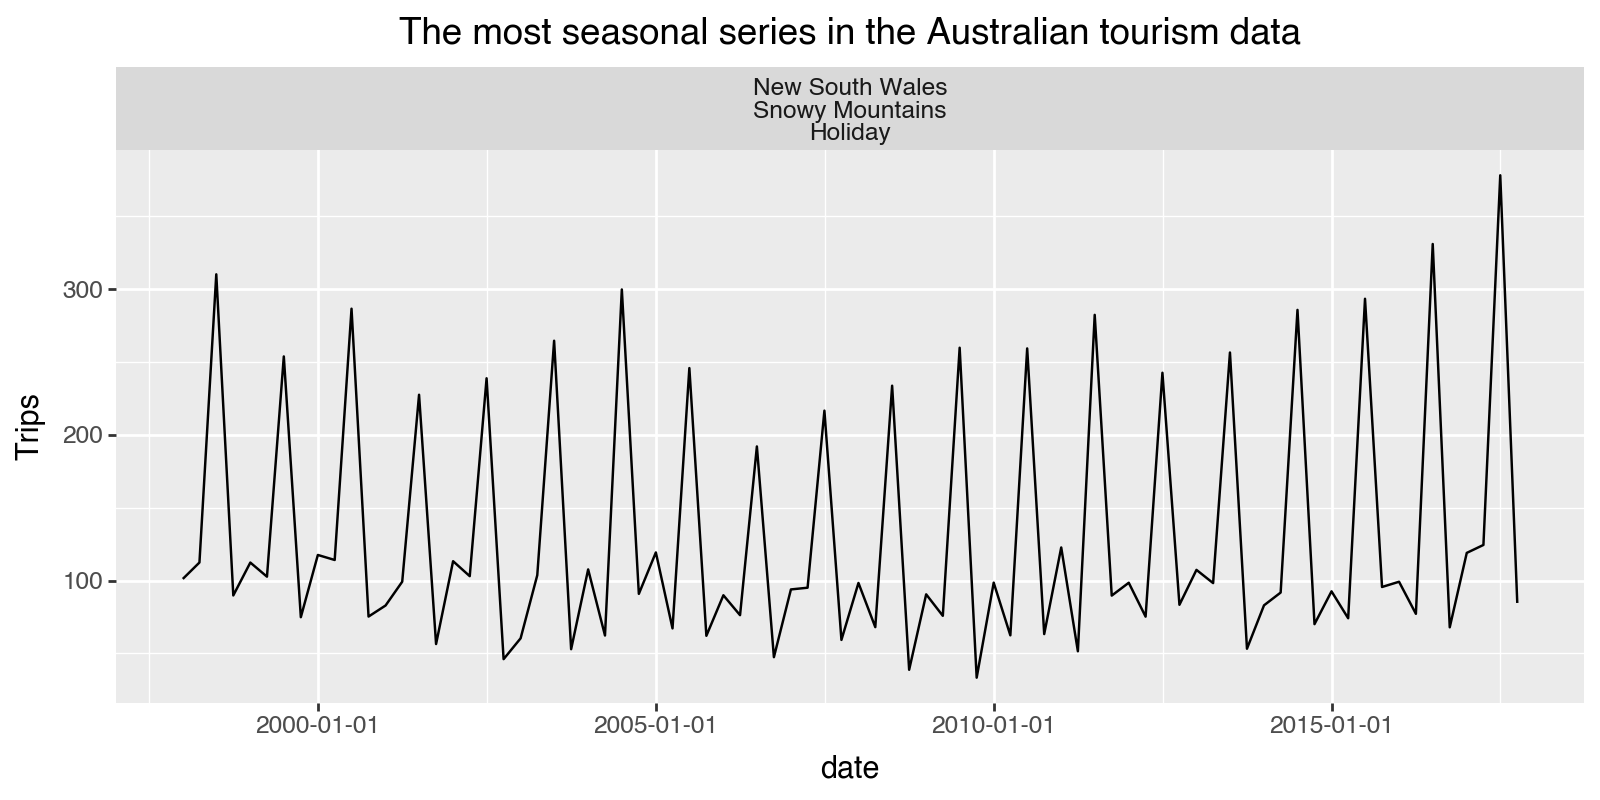

In [61]:
most_seasonal = (results
.query("season_strength == season_strength.max()")
.merge(tourism, on=['Region', 'State', 'Purpose'])
) 
ggplot(most_seasonal) \
    + aes(x='date', y='Trips') \
    + geom_line() \
    + facet_grid(cols=['State', 'Region', 'Purpose']) \
    + labs(title='The most seasonal series in the Australian tourism data') \
    + theme(figure_size=(8, 4))

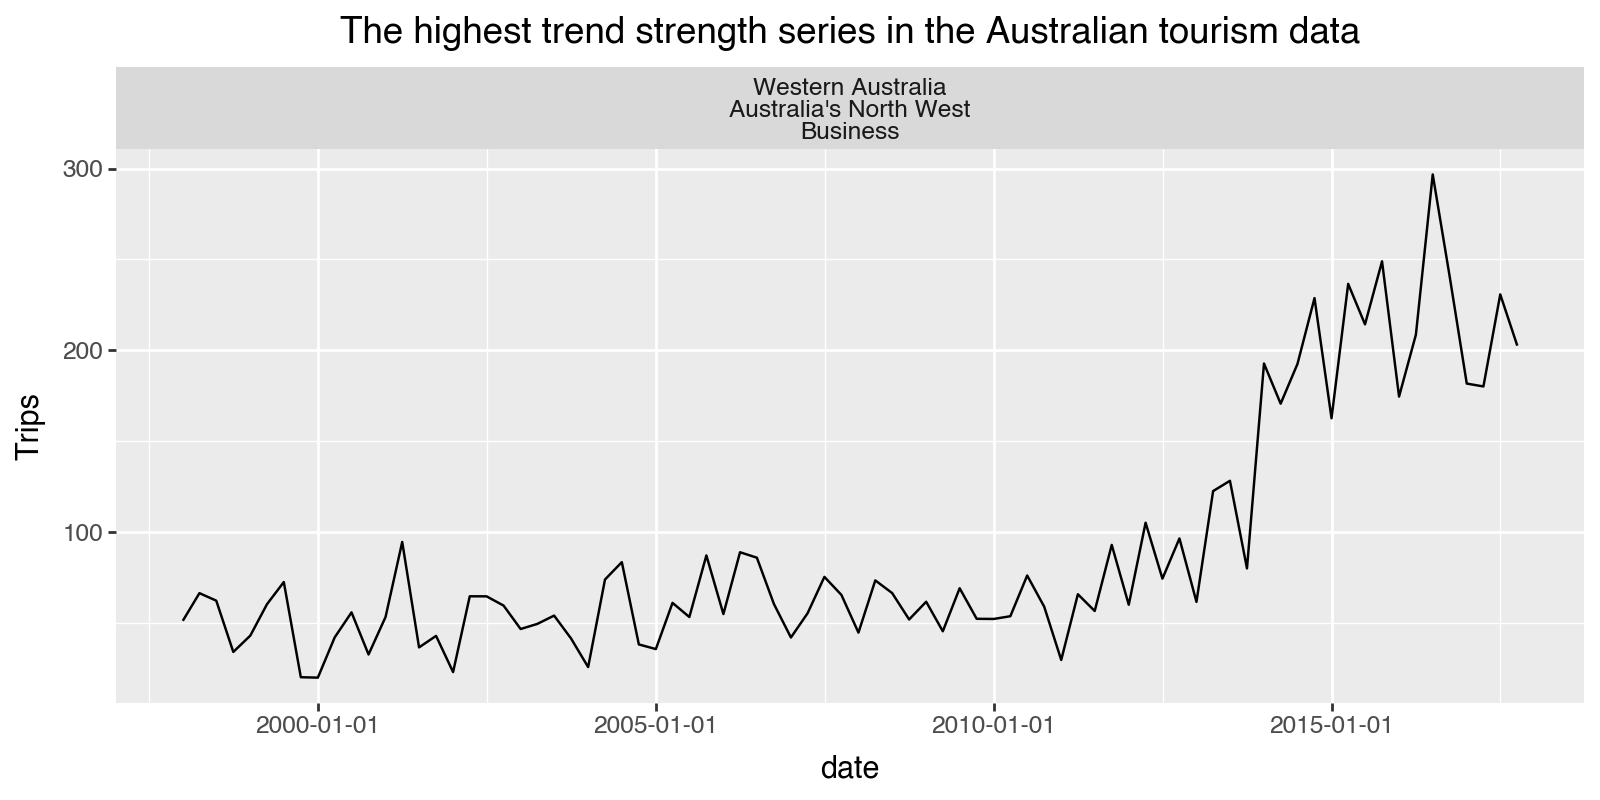

In [62]:
highest_trend = (results
.query("trend_strength == trend_strength.max()")
.merge(tourism, on=['Region', 'State', 'Purpose'])
) 
ggplot(highest_trend) \
    + aes(x='date', y='Trips') \
    + geom_line() \
    + facet_grid(cols=['State', 'Region', 'Purpose']) \
    + labs(title='The highest trend strength series in the Australian tourism data') \
    + theme(figure_size=(8, 4))